In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
import datetime
import csv
import math
import time
from ProgressBar import ProgressBar
import scipy
import pickle
import cPickle


import nltk
import string
from collections import defaultdict
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.decomposition import LatentDirichletAllocation
from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import KFold
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import r2_score
from pandas.tools.plotting import scatter_matrix

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import StandardScaler

/Users/kshain/anaconda/envs/AC209/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


# <center> Modeling & Results</center>

<ul>
<li><h3><a href="#Manipulating-the-Data">Manipulating the Data</a></h3></li>
<ul>
<li><a href="#Loading-the-data">Loading the data</a></li>
<li><a href="#Adding-lags">Adding lags</a></li>
</ul>
<li><h3><a href="#Modeling">Modeling</a></h3><ul>
<li><a href="#Windowed-Leave-one-out cross-validation">Windowed Leave-one-out cross validation</a></li>
<li><a href="#Feature-selection">Feature selection</a></li>
<li><a href="#Trying-various-models">Trying various models</a></li>
<li><a href="#Ensemble-model">Ensemble model</a></li>
</ul>
</li>
<li><h3><a href="#Results">Results</a></h3></li>
</ul>

## Manipulating the Data

None of the models we have learned in class immediately apply to this dataset because the observations are correlated in time. One way to convert into a form with uncorrelated observations is to encode lagged values as features of the current observation. We choose the lags to include based on the significant terms in the ARIMA model. With all of the important temporal information encoded as features, we will not lose information by treating the observations as independent. 

### Loading the data

We will be using the CCI, SentiWordNet scores, and LDA topic scores so we need to load all of them.

In [2]:
CCI = pd.read_csv('CCI.csv')[['TIME','Value']]
CCI.set_index('TIME', inplace=True)
CCI.columns = ['CCI']
CCIlimited = CCI.iloc[np.where(CCI.index=='1990-01')[0][0]:(np.where(CCI.index=='2016-09')[0]+1)[0]]
CCIlimited.head()

,CCI
TIME,
1990-01,100.6027
1990-02,100.5847
1990-03,100.6537
1990-04,100.7061
1990-05,100.5763


In [3]:
sentiDF = pd.read_csv('daily_sentiment_1990_2016.csv')
sentiDF.head()

,date,score,count,avg_score
0,1990-01-01,9.250,535.0,0.017290
1,1990-01-02,17.875,1020.0,0.017525
2,1990-01-03,29.875,1291.0,0.023141
3,1990-01-04,24.500,981.0,0.024975
4,1990-01-05,22.750,991.0,0.022957


In [4]:
sentiDF['yearmonth'] = sentiDF.date.apply(lambda x: x[:7])

In [5]:
sentiDF = sentiDF.groupby('yearmonth').sum()

In [6]:
sentiDF['full_avg'] = sentiDF.score/sentiDF['count']
sentiDF.head()

,score,count,avg_score,full_avg
yearmonth,,,,
1990-01,767.819,55530.0,0.468651,0.013827
1990-02,675.360,55170.0,0.380867,0.012241
1990-03,725.750,56620.0,0.448966,0.012818
1990-04,826.457,62133.0,0.422635,0.013301
1990-05,796.319,56484.0,0.483349,0.014098


In [7]:
topicsByMonthBigrams = np.load('topicsByMonthBigrams8.npy')

In [8]:
n_topics=8
topicsDF = pd.DataFrame(topicsByMonthBigrams)
topicsDF.columns = ['Topic_{}'.format(i) for i in range(1,(n_topics+1))]
topicsDF.index = CCIlimited.index
topicsDF.head()

,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6,Topic_7,Topic_8
TIME,,,,,,,,
1990-01,1.913982,1.461154,0.828178,2.491152,17.328913,1.249416,1.802758,1.683289
1990-02,1.733826,1.287834,0.853428,2.340800,18.754974,1.077555,1.711945,1.400007
1990-03,1.971802,1.542993,1.444748,2.756039,15.394626,1.198170,2.060474,1.643949
1990-04,1.501901,1.433842,1.319508,2.064651,16.626989,1.061051,1.546536,2.067808
1990-05,1.981963,1.603194,1.433641,2.465391,14.500635,1.146554,1.750590,2.241273


Then, we can put all of the columns into one dataframe.

In [9]:
topicsSentiCCI = pd.concat([CCIlimited, topicsDF, sentiDF.full_avg], axis=1)

### Adding lags

We want to predict one month ahead, so we limit the features to lagging at least one month behind the target observation. Pandas includes the `shift` function which can nicely offset a column, which has the same effect as getting the lagged value since our data is ordered to begin with. Lastly, we want to obtain a dataframe using all of the predictors lagged and another just using the lagged CCI to use as a baseline.

In [10]:
CCIdf = pd.DataFrame(CCIlimited)

In [11]:
def applyShifts(df, shifts):
    finaldf = df
    for i in shifts:
        newdf = df.shift(periods=i)
        newdf.columns = [s + '_lag_{}'.format(i) for s in df.columns]
        finaldf = pd.concat([finaldf, newdf], axis=1)
    finaldf = finaldf.dropna(how="any", axis=0)
    return finaldf

In [12]:
topicsSentiCCI_withLags = applyShifts(topicsSentiCCI, [1,2]) # All predictors lagged

In [13]:
CCI_withLags = applyShifts(CCIdf, [1,2]) # Just CCI for baseline

In [14]:
topicsSentiCCI_withLags.head()

,CCI,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6,Topic_7,Topic_8,full_avg,CCI_lag_1,Topic_1_lag_1,Topic_2_lag_1,Topic_3_lag_1,Topic_4_lag_1,Topic_5_lag_1,Topic_6_lag_1,Topic_7_lag_1,Topic_8_lag_1,full_avg_lag_1,CCI_lag_2,Topic_1_lag_2,Topic_2_lag_2,Topic_3_lag_2,Topic_4_lag_2,Topic_5_lag_2,Topic_6_lag_2,Topic_7_lag_2,Topic_8_lag_2,full_avg_lag_2
1990-03,100.6537,1.971802,1.542993,1.444748,2.756039,15.394626,1.198170,2.060474,1.643949,0.012818,100.5847,1.733826,1.287834,0.853428,2.340800,18.754974,1.077555,1.711945,1.400007,0.012241,100.6027,1.913982,1.461154,0.828178,2.491152,17.328913,1.249416,1.802758,1.683289,0.013827
1990-04,100.7061,1.501901,1.433842,1.319508,2.064651,16.626989,1.061051,1.546536,2.067808,0.013301,100.6537,1.971802,1.542993,1.444748,2.756039,15.394626,1.198170,2.060474,1.643949,0.012818,100.5847,1.733826,1.287834,0.853428,2.340800,18.754974,1.077555,1.711945,1.400007,0.012241
1990-05,100.5763,1.981963,1.603194,1.433641,2.465391,14.500635,1.146554,1.750590,2.241273,0.014098,100.7061,1.501901,1.433842,1.319508,2.064651,16.626989,1.061051,1.546536,2.067808,0.013301,100.6537,1.971802,1.542993,1.444748,2.756039,15.394626,1.198170,2.060474,1.643949,0.012818
1990-06,100.2907,3.757367,2.412851,1.542730,5.385177,0.700988,2.175334,3.724585,2.684647,0.020079,100.5763,1.981963,1.603194,1.433641,2.465391,14.500635,1.146554,1.750590,2.241273,0.014098,100.7061,1.501901,1.433842,1.319508,2.064651,16.626989,1.061051,1.546536,2.067808,0.013301
1990-07,99.8083,2.129353,1.503426,1.377753,2.539549,15.332070,1.273006,2.108370,2.016001,0.013509,100.2907,3.757367,2.412851,1.542730,5.385177,0.700988,2.175334,3.724585,2.684647,0.020079,100.5763,1.981963,1.603194,1.433641,2.465391,14.500635,1.146554,1.750590,2.241273,0.014098


At this point, we still have the unlagged columns in our dataframes, so we have to drop all of those columns.

In [15]:
y = topicsSentiCCI_withLags.CCI
X = topicsSentiCCI_withLags.drop(topicsSentiCCI.columns, axis=1)
X_justCCI = CCI_withLags.drop(['CCI'], axis=1)

In [16]:
pd.concat([y,X],axis=1).head()

,CCI,CCI_lag_1,Topic_1_lag_1,Topic_2_lag_1,Topic_3_lag_1,Topic_4_lag_1,Topic_5_lag_1,Topic_6_lag_1,Topic_7_lag_1,Topic_8_lag_1,full_avg_lag_1,CCI_lag_2,Topic_1_lag_2,Topic_2_lag_2,Topic_3_lag_2,Topic_4_lag_2,Topic_5_lag_2,Topic_6_lag_2,Topic_7_lag_2,Topic_8_lag_2,full_avg_lag_2
1990-03,100.6537,100.5847,1.733826,1.287834,0.853428,2.340800,18.754974,1.077555,1.711945,1.400007,0.012241,100.6027,1.913982,1.461154,0.828178,2.491152,17.328913,1.249416,1.802758,1.683289,0.013827
1990-04,100.7061,100.6537,1.971802,1.542993,1.444748,2.756039,15.394626,1.198170,2.060474,1.643949,0.012818,100.5847,1.733826,1.287834,0.853428,2.340800,18.754974,1.077555,1.711945,1.400007,0.012241
1990-05,100.5763,100.7061,1.501901,1.433842,1.319508,2.064651,16.626989,1.061051,1.546536,2.067808,0.013301,100.6537,1.971802,1.542993,1.444748,2.756039,15.394626,1.198170,2.060474,1.643949,0.012818
1990-06,100.2907,100.5763,1.981963,1.603194,1.433641,2.465391,14.500635,1.146554,1.750590,2.241273,0.014098,100.7061,1.501901,1.433842,1.319508,2.064651,16.626989,1.061051,1.546536,2.067808,0.013301
1990-07,99.8083,100.2907,3.757367,2.412851,1.542730,5.385177,0.700988,2.175334,3.724585,2.684647,0.020079,100.5763,1.981963,1.603194,1.433641,2.465391,14.500635,1.146554,1.750590,2.241273,0.014098


## Modeling

### Windowed Leave-one-out cross validation

Though the temporal information is redundantly encoded so we can use a model with independent observations, the observations are still not actually independent. Therefore, we do not want to evaluate the model on a test set that is dependent on the training set. To do this, we use a variation of leave-one-out cross validation that excludes a window around the test observation from use in the training set ([reference](http://directory.umm.ac.id/Data%20Elmu/jurnal/J-a/Journal%20of%20Econometrics/Vol99.Issue1.Nov2000/2139.pdf)). The window extends forward and backward from the test observation by the number of correlated lags derived from ARIMA.

In practice, this amounts to doing LOOCV but also leaving out a larger window from the training set.
<img src="WLOOCV.png">

In [17]:
def evaluateModel_LOOCV(model, X, y, n_lags=14):
    n = len(y)
    RSS = 0
    TSS = np.sum(np.square(y-np.mean(y)))
    pred = np.zeros(n)
    
    for i in range(n):
        
        
        X_test = X.iloc[i]
        y_test = y.iloc[i]

        train_indexes = list(range(i-n_lags))
        train_indexes.extend(range(i+n_lags,n))
        
        X_train = X.iloc[train_indexes]
        y_train = y.iloc[train_indexes]
        scaler = StandardScaler()
        
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        model.fit(X_train_scaled, y_train)
        pred[i] = model.predict(X_test_scaled)
        RSS += np.square(pred[i]-y_test)
    R2 = (1-RSS/TSS)
    MSE = RSS/n
    return(R2, MSE, pred)

### Feature selection

Before model selection, feature selection is performed using Lasso regularization. This is because the model quickly becomes higher dimensional by including several lags of the CCI, topic scores, and sentiment scores. Lasso allows for the flexibility of considering many lags, while still producing a parsimonious model. The regularization parameter is chosen by windowed cross validation.

In [30]:
alphas = [.000001,.00001,.0001,.001,.01,.1]
R2 = np.zeros(len(alphas))
for i, alpha in enumerate(alphas):
    model = Lasso(alpha = alpha)
    R2[i] = evaluateModel_LOOCV(model, X, y, n_lags=3)[0]

In [31]:
pd.DataFrame(R2.reshape((1,len(R2))), columns = alphas, index=['R-squared'])

,1e-06,1e-05,0.0001,0.001,0.01,0.1
R-squared,0.989603,0.98961,0.98965,0.989638,0.980689,0.968001


In [18]:
lasso = Lasso(alpha=0.001) #best from CV
evaluateModel_LOOCV(lasso, X, y, n_lags=3)[0]

0.9896380441977396

We can look at the coefficients from the Lasso model and drop the features that have coefficients of zero.

In [19]:
pd.DataFrame(lasso.coef_.reshape((1,len(lasso.coef_))), columns = X.columns)

,CCI_lag_1,Topic_1_lag_1,Topic_2_lag_1,Topic_3_lag_1,Topic_4_lag_1,Topic_5_lag_1,Topic_6_lag_1,Topic_7_lag_1,Topic_8_lag_1,full_avg_lag_1,CCI_lag_2,Topic_1_lag_2,Topic_2_lag_2,Topic_3_lag_2,Topic_4_lag_2,Topic_5_lag_2,Topic_6_lag_2,Topic_7_lag_2,Topic_8_lag_2,full_avg_lag_2
0,2.448962,-0.045274,-0.0,-0.01279,-0.0,-0.003307,-0.0,-0.025455,0.100428,-0.0,-1.028818,-0.0,0.0,-0.0,-0.0,0.042149,0.0,-0.0,0.028887,-0.016995


In [20]:
X_subset = X.drop(X.columns[np.where(lasso.coef_==0)], axis=1)

### Trying various models

With the features selected via Lasso, we tried linear regression, SVM, random forest, and gradient boosting. Linear regression and a tuned SVM were both very successful.

In [21]:
lr = LinearRegression()
R2_LR, MSE_LR, pred_LR = evaluateModel_LOOCV(lr, X_subset, y, n_lags=3)

In [27]:
print 'All Predictor Forecasting MSE = {:.3f}'.format(MSE_LR)

All Predictor Forecasting MSE = 0.021


In [23]:
lr = LinearRegression()
R2_CCI, MSE_CCI, predCCI = evaluateModel_LOOCV(lr, X_justCCI, y, n_lags=3)

In [28]:
print 'Just CCI Forecasting MSE = {:.3f}'.format(MSE_CCI)

Just CCI Forecasting MSE = 0.023


## SVM

In [32]:
gammas = [.00001,.0001]
R2 = np.zeros(len(gammas))
for i, gamma in enumerate(gammas):
    model = SVR(C = 100000, kernel = 'rbf', gamma=gamma)
    R2[i] = evaluateModel_LOOCV(model, X_subset, y, n_lags=3)[0]   

In [33]:
pd.DataFrame(R2.reshape((1,len(R2))), columns = gammas, index=['R-squared'])

,1e-05,0.0001
R-squared,0.989933,0.988687


In [35]:
model = SVR(C = 100000, kernel = 'rbf', gamma=0.00001)
R2_SVR, MSE_SVR, pred_SVR = evaluateModel_LOOCV(model, X_subset, y, n_lags=3)  

In [36]:
print 'All Predictor SVR Forecasting MSE = {:.3f}'.format(MSE_SVR)

All Predictor SVR Forecasting MSE = 0.021


## Ensemble learner

It turns out that a combination of linear regression and support vector regression is better than either one on its own. They are combined by feeding their outputs into another SVR model. In essence, this trains another model that weights the LR and SVR model based on where they perform best in the feature space.

In [37]:
def evaluateModel_LOOCV_ensemble(models, X, y, n_lags=14):
    n = len(y)
    RSS = 0
    TSS = np.sum(np.square(y-np.mean(y)))
    pred = np.zeros(n)
    for i in range(n):
        
        
        X_test = X.iloc[i]
        y_test = y.iloc[i]

        train_indexes = list(range(i-n_lags))
        train_indexes.extend(range(i+n_lags,n))
        
        X_train = X.iloc[train_indexes]
        y_train = y.iloc[train_indexes]
        scaler = StandardScaler()
        
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        X_train_with_model_output = X_train_scaled
        X_test_with_model_output = X_test_scaled
        
        for model in models:
            model.fit(X_train_scaled, y_train)
            X_train_with_model_output = np.concatenate((X_train_with_model_output,model.predict(X_train_scaled).reshape((len(y_train),1))),axis=1)
            X_test_with_model_output = np.hstack((X_test_with_model_output,model.predict(X_test_scaled)))
            
        
        svr = SVR(C = 100000, kernel = 'rbf', gamma=.00001)
        svr.fit(X_train_with_model_output, y_train)
        pred[i] = svr.predict(X_test_with_model_output)
        RSS += np.square(pred[i]-y_test)
    R2 = (1-RSS/TSS)
    MSE = RSS/n
    return(R2, MSE, pred)

In [38]:
models = [LinearRegression(), SVR(C = 100000, kernel = 'rbf', gamma=0.00001)]
R2_ens, MSE_ens, pred_ens = evaluateModel_LOOCV_ensemble(models, X_subset, y, n_lags=3)

In [40]:
print 'All Predictor Ensemble Forecasting MSE = {:.4f}'.format(MSE_ens)

All Predictor Ensemble Forecasting MSE = 0.0210


## Results

The ensemble of linear regression and SVM achieved $R^2_{CV}=0.990$ and $RMSE_{CV}=0.145$. This is only slightly better than just using CCI, which gets $RMSE_{CV}=0.151$

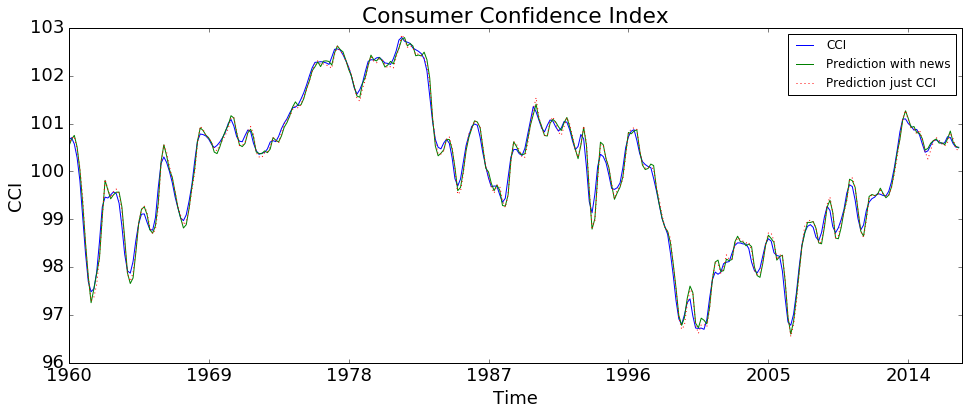

In [467]:
matplotlib.rcParams.update({'font.size': 18})
fig = plt.figure(figsize=(16,6))
ax = fig.add_subplot(111)
ax.plot(range(len(y)),y.values, label='CCI')
ax.plot(pred, label='Prediction with news')
ax.plot(predCCI, label='Prediction just CCI', linestyle='dotted')
ax.set_title('Consumer Confidence Index')
ax.set_ylabel('CCI')
ax.set_xlim((0,len(y)))
ax.set_xlabel('Time')
ax.set_xticklabels(list(np.arange(1960,2017,9)));
ax.legend(loc='best',prop={'size':12})
plt.savefig('CCIwithPrediction.png', bbox_inches='tight')

Using the news data helps forecast the sharp changes in CCI a little better than just using previous CCI values. However, the difference is slight.